# Binary Classification

## Load Dataset from sklearn

In [4]:
!pip install sklearn

     |████████████████████████████████| 7.2 MB 9.1 MB/s eta 0:00:01     |████████████████▌               | 3.7 MB 2.3 MB/s eta 0:00:02
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=b15c8acf06155794e515162a8e9f3c0d94bbd1d011a9660d4a7a396144ac541f
  Stored in directory: /Users/hyun/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.datasets import load_breast_cancer # sklearn의 유방암 데이터 불러오기
cancer = load_breast_cancer()

In [6]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [7]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

## Convert to PyTorch Tensor

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
data = torch.from_numpy(df.values).float() # double -> float 형 변환

data.shape

torch.Size([569, 31])

In [10]:
x = data[:, :10] # 앞의 10개 피쳐만 취함
y = data[:, -1:] # 레이블인 마지막 피쳐만

print(x.shape, y.shape)

torch.Size([569, 10]) torch.Size([569, 1])


In [11]:
# Train / Valid / Test ratio
ratios = [.6, .2, .2]

In [12]:
train_cnt = int(data.size(0) * ratios[0])
valid_cnt = int(data.size(0) * ratios[1])
test_cnt = data.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

Train 341 / Valid 113 / Test 115 samples.


In [13]:
indices = torch.randperm(data.size(0)) # 셔플링 및 split 청킹

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


You don't need to shuffle them, if you have fixed train/valid/test set.

## Set Hyper Parameters

In [14]:
n_epochs = 10000
batch_size = 128
print_interval = 500
early_stop = 100

## Get DataLoaders

In [15]:
from torch.utils.data import Dataset, DataLoader # 임포트 !!

In [16]:
class CustomDataset(Dataset): # 세 함수 오버라이딩 필수 !!
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
        super().__init__()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx): # 실제 미니배치를 만드는 함수
        return self.data[idx], self.labels[idx] # (튜플로 리턴)

In [17]:
train_loader = DataLoader( # DataLoader() !!
    dataset=CustomDataset(x[0], y[0]), # (data, label)
    batch_size=batch_size,
    shuffle=True, # Allow shuffling only for training set. !!
)
valid_loader = DataLoader(
    dataset=CustomDataset(x[1], y[1]),
    batch_size=batch_size,
    shuffle=False, # 셔플링 X
)
test_loader = DataLoader(
    dataset=CustomDataset(x[2], y[2]),
    batch_size=batch_size,
    shuffle=False, # 셔플링 X
)

print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset), # dataset !!
    len(valid_loader.dataset),
    len(test_loader.dataset),
))

Train 341 / Valid 113 / Test 115 samples.


## Build Model & Optimizer

In [18]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6), # x[0].size(-1): training_set의 마지막 dimension => 10차원(feature)
    nn.LeakyReLU(),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid(),
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
  (9): Sigmoid()
)

In [19]:
optimizer = optim.Adam(model.parameters())

## Train

In [20]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [21]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    # We can remove following code block. (## DataLoader가 있기 때문에 이제 필요 없음 !!)
    # ------------------------------------------------------
    # indices = torch.randperm(x[0].size(0))
    # x_ = torch.index_select(x[0], dim=0, index=indices)
    # y_ = torch.index_select(y[0], dim=0, index=indices)
    #
    # x_ = x_.split(batch_size, dim=0)
    # y_ = y_.split(batch_size, dim=0)
    # ------------------------------------------------------

    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(train_loader)
        
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(valid_loader)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 500: train loss=3.0157e-01  valid_loss=2.9053e-01  lowest_loss=2.8925e-01
There is no improvement during last 100 epochs.
The best validation loss from epoch 684: 2.6330e-01


<All keys matched successfully>

## Loss History

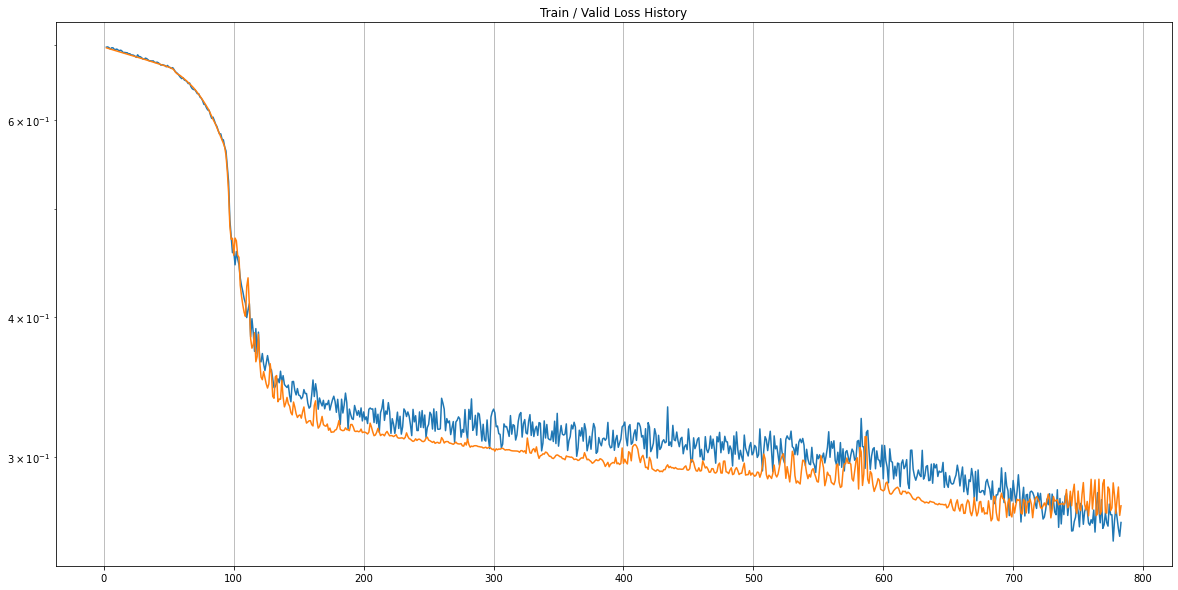

In [22]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## Let's see the result!

In [23]:
test_loss = 0
y_hat = []

model.eval() # test !!
with torch.no_grad(): # test !!
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i] # |y_hat_i| : (bs, 1) = (bs, k, 1) # bs = test_cnt(?)

test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 2.9871e-01


In [24]:
correct_cnt = (y[2] == (y_hat > .5)).sum() # correct_cnt: 전체 맞은 갯수를 구할 수 있음 !!
### y_hat이 0.5보다 크면 1로 분포되어 있을 것임 (이 규칙 활용해 inferrence ???)
total_cnt = float(y[2].size(0)) # total_cnt : 전체 Test set의 사이즈 (115개)

print('Test Accuracy: %.4f' % (correct_cnt / total_cnt))

Test Accuracy: 0.8870


In [27]:
y[2].size()

torch.Size([115, 1])

In [28]:
y

(tensor([[0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [